In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr

In [ ]:
TMFsim = pd.read_csv("./data/TMFSIM.csv")
UPROsim = pd.read_csv("./data/UPROSIM.csv")
LEV = 3

UPROsim["UPRO"] = UPROsim["UPRO"].str.replace("%", "").astype("float")
TMFsim["TMF"] = TMFsim["TMF"].str.replace("%", "").astype("float")
FFR = pd.read_csv("./data/FFR.csv")

FFR['Date'] = pd.to_datetime(FFR['Date'], format='%Y-%m-%d')
# Cost of borrowing to achieve 3x exposure:
FFR

,Date,FFR
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
831,2023-10-01,5.33
832,2023-11-01,5.33
833,2023-12-01,5.33
834,2024-01-01,5.33


In [ ]:
TMFsim['Date'] = pd.to_datetime(TMFsim['Date'], format='%m/%d/%y')

UPROsim['Date'] = pd.to_datetime(UPROsim['Date'], format='%m/%d/%y')
UPROsim.rename(columns={'UPRO': 'UPRO_sim'}, inplace=True)
TMFsim.rename(columns={'TMF': 'TMF_sim'}, inplace=True)

display(TMFsim.iloc[:, :-1].head())
display(UPROsim.iloc[:, :-1].head())


,Date,TMF_sim
0,1986-05-20,-0.6
1,1986-05-21,3.0
2,1986-05-22,-0.6
3,1986-05-23,0.6
4,1986-05-27,1.3


,Date,UPRO_sim
0,1986-05-20,3.7
1,1986-05-21,-0.7
2,1986-05-22,5.9
3,1986-05-23,1.4
4,1986-05-27,4.2


In [ ]:
spy = yf.Ticker("SPY")
spy.info

{'longBusinessSummary': 'The Trust seeks to achieve its investment objective by holding a portfolio of the common stocks that are included in the index (the “Portfolio”), with the weight of each stock in the Portfolio substantially corresponding to the weight of such stock in the index.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 519.77,
 'open': 521.23,
 'dayLow': 518.4,
 'dayHigh': 521.58,
 'regularMarketPreviousClose': 519.77,
 'regularMarketOpen': 521.23,
 'regularMarketDayLow': 518.4,
 'regularMarketDayHigh': 521.58,
 'trailingPE': 26.134783,
 'volume': 65217647,
 'regularMarketVolume': 65217647,
 'averageVolume': 75202062,
 'averageVolume10days': 74524500,
 'averageDailyVolume10Day': 74524500,
 'bidSize': 1800,
 'askSize': 2200,
 'yield': 0.012999999,
 'totalAssets': 503321591808,
 'fiftyTwoWeekLow': 398.68,
 'fiftyTwoWeekHigh': 524.11,
 'fiftyDayAverage': 501.3642,
 'twoHundredDayAverage': 459.7722,
 'trailingAnnualDividendRate': 5.662,
 'trailingAnnualDividendYield':

In [ ]:
HFEA = yf.Tickers("spy tlt")
spy = HFEA.tickers["SPY"]
tlt = HFEA.tickers["TLT"]

In [ ]:
yf.pdr_override()
real_data = yf.download("SPY TLT")

[*********************100%%**********************]  2 of 2 completed


In [ ]:
data = pd.merge_asof(real_data['Close'].sort_values('Date'),
                            FFR.sort_values('Date'),
                            on='Date',
                            direction='backward')

data


,Date,SPY,TLT,FFR
0,1993-01-29,43.937500,NaN,3.02
1,1993-02-01,44.250000,NaN,3.03
2,1993-02-02,44.343750,NaN,3.03
3,1993-02-03,44.812500,NaN,3.03
4,1993-02-04,45.000000,NaN,3.03
...,...,...,...,...
7840,2024-03-20,520.479980,92.889999,5.33
7841,2024-03-21,522.200012,93.089996,5.33
7842,2024-03-22,521.210022,93.980003,5.33
7843,2024-03-25,519.770020,93.510002,5.33


## Attempt to calculate borrow cost
(Daily % chg in underlying index) * lev - ER/250 - (lev - 1) * (FFR) * (cur date - prev date)/360:


In [ ]:
def naive_leverage(df, tickers, lev = 1):
    tickers_list = list(tickers.keys())
    new_names = [ f"{lev}x{x}" for x in tickers_list]
    df_pct = df.copy()
    df_pct[new_names] = df[tickers_list].pct_change() * lev * 100
    return df_pct

def leverage(df, tickers, expense_ratio, leverage=3):
    df = df.copy()
    df['prev_date'] = df['Date'].shift(1)
    df['days_diff'] = (pd.to_datetime(df['Date']) - pd.to_datetime(df['prev_date'])).dt.days.fillna(0)
    
    for ticker, letf in tickers.items():
        df[f"{letf}_ours"] = df[ticker].pct_change() * leverage
        df[f"{letf}_ours"] -= (expense_ratio / 250)
        df[f"{letf}_ours"] -= (leverage - 1) * (df['FFR'] / 100) * (df['days_diff'] / 360)
        df[f"{letf}_ours"] *= 100

    
    df.drop(columns=['prev_date'], inplace=True)
    return df

### 3x* baselines, our sim:

In [ ]:
tickers = {'SPY': 'UPRO', 'TLT': 'TMF'}
pct_change_df = naive_leverage(data, tickers, LEV)
pct_change_df = leverage(pct_change_df, tickers, 0.0092, LEV)
pct_change_df['Date'] = pd.to_datetime(pct_change_df['Date'])

pct_change_df

,Date,SPY,TLT,FFR,3xSPY,3xTLT,days_diff,UPRO_ours,TMF_ours
0,1993-01-29,43.937500,NaN,3.02,NaN,NaN,0.0,NaN,NaN
1,1993-02-01,44.250000,NaN,3.03,2.133713,NaN,3.0,2.079533,NaN
2,1993-02-02,44.343750,NaN,3.03,0.635593,NaN,1.0,0.615080,NaN
3,1993-02-03,44.812500,NaN,3.03,3.171247,NaN,1.0,3.150734,NaN
4,1993-02-04,45.000000,NaN,3.03,1.255230,NaN,1.0,1.234717,NaN
...,...,...,...,...,...,...,...,...,...
7840,2024-03-20,520.479980,92.889999,5.33,2.774791,-0.096854,1.0,2.741500,-0.130145
7841,2024-03-21,522.200012,93.089996,5.33,0.991411,0.645915,1.0,0.958120,0.612624
7842,2024-03-22,521.210022,93.980003,5.33,-0.568742,2.868215,1.0,-0.602033,2.834924
7843,2024-03-25,519.770020,93.510002,5.33,-0.828842,-1.500323,3.0,-0.921355,-1.592836


### Add Hedgefundie's sim data:

In [ ]:
joined_df = pd.merge(pct_change_df, TMFsim.iloc[:, :-1], on='Date', how='outer')
joined_df = pd.merge(joined_df, UPROsim.iloc[:, :-1], on='Date', how='outer')
joined_df.set_index(joined_df.columns[0], inplace=True)

joined_df.sort_values(by='Date', inplace=True)
joined_df[5500:6000]

,SPY,TLT,FFR,3xSPY,3xTLT,days_diff,UPRO_ours,TMF_ours,TMF_sim,UPRO_sim
Date,,,,,,,,,,
2008-03-11,132.600006,92.790001,2.61,10.781264,-2.564362,1.0,10.763084,-2.582542,-3.6,11.1
2008-03-12,131.360001,94.580002,2.61,-2.805442,5.787264,1.0,-2.823622,5.769084,4.9,-2.7
2008-03-13,131.649994,93.839996,2.61,0.662287,-2.347237,1.0,0.644107,-2.365417,-2.3,1.5
2008-03-14,129.610001,95.000000,2.61,-4.648675,3.708452,1.0,-4.666855,3.690272,3.3,-6.3
2008-03-17,128.300003,95.730003,2.61,-3.032168,2.305274,3.0,-3.079348,2.258094,1.0,-2.7
...,...,...,...,...,...,...,...,...,...,...
2010-02-26,110.739998,91.669998,0.13,0.189752,1.546057,1.0,0.185350,1.541654,1.8,0.4
2010-03-01,111.889999,91.339996,0.16,3.115410,-1.079967,3.0,3.109063,-1.086313,0.3,3.0
2010-03-02,112.199997,91.220001,0.16,0.831167,-0.394116,1.0,0.826598,-0.398685,-0.3,0.7


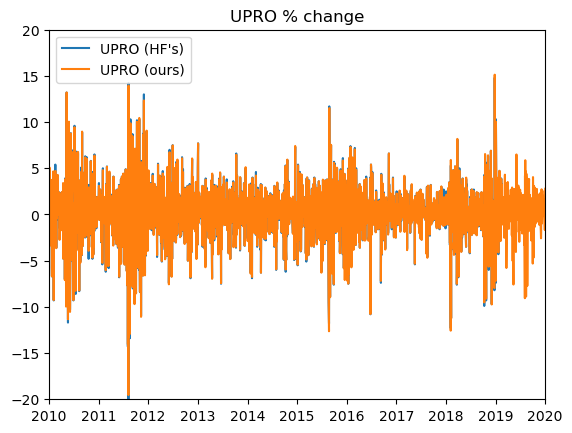

In [ ]:
start = "2010"

plt.plot(joined_df["UPRO_sim"], label = "UPRO (HF's)")
plt.plot(joined_df["UPRO_ours"], label="UPRO (ours)")
# plt.plot(joined_df["3xSPY"], label="3x S&P 500")
plt.legend()
plt.title("UPRO % change")
plt.ylim(-20,20)
plt.xlim(pd.to_datetime(start), pd.to_datetime("2020"))
plt.show()


/usr/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


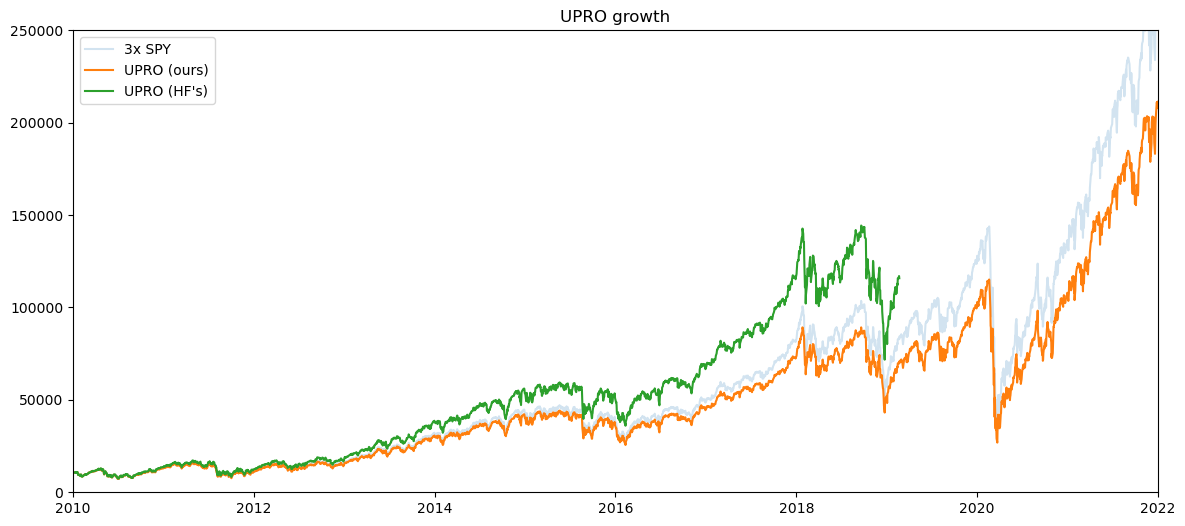

In [ ]:
INIT = 10000

def growth(joined_df, start="1970"):
    # Set the first column as the index
    index = joined_df["UPRO_sim"].index.searchsorted(start)
    coeffs = 1 + joined_df.iloc[index:, :] / 100
    return INIT * coeffs.cumprod()

plt.figure(figsize=(14, 6))  # Adjust the width as needed
df = growth(joined_df, start)
plt.plot(df["3xSPY"], label="3x SPY", alpha=0.2)
plt.plot(df["UPRO_ours"], label="UPRO (ours)")
plt.plot(df["UPRO_sim"], label = "UPRO (HF's)")
plt.title("UPRO growth")
plt.legend()
plt.ylim(0, 250000)
plt.xlim(pd.to_datetime(start), pd.to_datetime("2022"))
plt.show()


# Attempt to simulate UPRO by calculating external cost

In [ ]:
yf.pdr_override()
HFEA_data = yf.download("SPY UPRO TLT TMF")

[*********************100%%**********************]  4 of 4 completed


In [ ]:
HFEA_data

Price        Adj Close                                        Close  \
Ticker             SPY        TLT        TMF       UPRO         SPY   
Date                                                                  
1993-01-29   24.763741        NaN        NaN        NaN   43.937500   
1993-02-01   24.939865        NaN        NaN        NaN   44.250000   
1993-02-02   24.992699        NaN        NaN        NaN   44.343750   
1993-02-03   25.256903        NaN        NaN        NaN   44.812500   
1993-02-04   25.362577        NaN        NaN        NaN   45.000000   
...                ...        ...        ...        ...         ...   
2024-03-20  520.479980  92.889999  51.860001  69.750000  520.479980   
2024-03-21  522.200012  93.089996  52.099998  70.339996  522.200012   
2024-03-22  521.210022  93.980003  53.560001  70.010002  521.210022   
2024-03-25  519.770020  93.510002  52.799999  69.419998  519.770020   
2024-03-26  518.809998  93.769997  53.279999  68.839996  518.809998   

Price                                              High             ...  \
Ticker            TLT        TMF       UPRO         SPY        TLT  ...   
Date                                                                ...   
1993-01-29        NaN        NaN        NaN   43.968750        NaN  ...   
1993-02-01        NaN        NaN        NaN   44.250000        NaN  ...   
1993-02-02        NaN        NaN        NaN   44.375000        NaN  ...   
1993-02-03        NaN        NaN        NaN   44.843750        NaN  ...   
1993-02-04        NaN        NaN        NaN   45.093750        NaN  ...   
...               ...        ...        ...         ...        ...  ...   
2024-03-20  92.889999  51.860001  69.750000  520.619995  93.790001  ...   
2024-03-21  93.089996  52.099998  70.339996  524.109985  93.430000  ...   
2024-03-22  93.980003  53.560001  70.010002  522.609985  94.209999  ...   
2024-03-25  93.510002  52.799999  69.419998  520.950012  93.750000  ...   
2024-03-26  93.769997  53.279999  68.839996  521.580017  93.870003  ...   

Price             Low                   Open                                   \
Ticker            TMF       UPRO         SPY        TLT        TMF       UPRO   
Date                                                                            
1993-01-29        NaN        NaN   43.968750        NaN        NaN        NaN   
1993-02-01        NaN        NaN   43.968750        NaN        NaN        NaN   
1993-02-02        NaN        NaN   44.218750        NaN        NaN        NaN   
1993-02-03        NaN        NaN   44.406250        NaN        NaN        NaN   
1993-02-04        NaN        NaN   44.968750        NaN        NaN        NaN   
...               ...        ...         ...        ...        ...        ...   
2024-03-20  50.840000  67.639999  515.770020  93.099998  52.200001  67.940002   
2024-03-21  51.520000  70.290001  523.390015  93.269997  52.380001  70.879997   
2024-03-22  53.270000  69.879997  522.109985  94.190002  53.959999  70.330002   
2024-03-25  52.419998  69.300003  519.799988  93.709999  53.130001  69.379997   
2024-03-26  52.389999  68.769997  521.229980  93.510002  52.799999  69.940002   

Price         Volume                                    
Ticker           SPY         TLT        TMF       UPRO  
Date                                                    
1993-01-29   1003200         NaN        NaN        NaN  
1993-02-01    480500         NaN        NaN        NaN  
1993-02-02    201300         NaN        NaN        NaN  
1993-02-03    529400         NaN        NaN        NaN  
1993-02-04    531500         NaN        NaN        NaN  
...              ...         ...        ...        ...  
2024-03-20  69594600  43460100.0  8692900.0  5927000.0  
2024-03-21  60256100  34276600.0  7914500.0  5468600.0  
2024-03-22  79023000  30258200.0  5815800.0  3515400.0  
2024-03-25  48512100  24011800.0  4403200.0  8511200.0  
2024-03-26  65348900  34414800.0  6337300.0  7717900.0  

[7845 rows x 24 colu

In [ ]:
tickers = {'SPY': 'UPRO', 'TLT': 'TMF'}

def leverage(df, tickers, lev = 1):
    pct_change_list = []

    for index, letf in tickers.items():
        if ('Close', index) in df.columns:
            # Calculate percentage change for the specified ticker's 'Close' price
            pct_change_series = df['Close', index].pct_change() * 100 * lev  # Multiply by 100 to convert to percentage
            pct_change_series.name = f"{lev}x{index}"  # Rename the Series for clarity
            pct_change_list.append(pct_change_series)

    # Concatenate all the percentage change Series into a single DataFrame
    if pct_change_list:
        pct_change_df = pd.concat(pct_change_list, axis=1)
        pct_change_df.index.name = 'Date'  # Assuming the DataFrame's index is Date
        # Reset index to turn the Date index into a column
        pct_change_df.reset_index(inplace=True)
        return pct_change_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no tickers were found or provided

pct_df = leverage(HFEA_data, tickers, LEV)

pct_df['Date'] = pd.to_datetime(pct_change_df['Date'])
if 'Date' in pct_df.columns:
    pct_df.set_index('Date', inplace=True)
# print(pct_df)

In [ ]:
upro_pct_change = HFEA_data['Close']['UPRO'].pct_change() * 100
tmf_pct_change = HFEA_data['Close']['TMF'].pct_change() * 100


# Join the new data with the original DataFrame based on 'Date' index
complete_df = pct_df.join(upro_pct_change).join(tmf_pct_change)

# If you want to convert 'Date' back from index to a column
complete_df.reset_index(inplace=True)
if 'Date' in complete_df.columns:
    complete_df.set_index('Date', inplace=True)
complete_df

,3xSPY,3xTLT,UPRO,TMF
Date,,,,
1993-01-29,NaN,NaN,NaN,NaN
1993-02-01,2.133713,NaN,NaN,NaN
1993-02-02,0.635593,NaN,NaN,NaN
1993-02-03,3.171247,NaN,NaN,NaN
1993-02-04,1.255230,NaN,NaN,NaN
...,...,...,...,...
2024-03-20,2.774791,-0.096854,2.513226,-0.115558
2024-03-21,0.991411,0.645915,0.845873,0.462780
2024-03-22,-0.568742,2.868215,-0.469142,2.802309


In [ ]:
complete_df

,3xSPY,3xTLT,UPRO,TMF
Date,,,,
1993-01-29,NaN,NaN,NaN,NaN
1993-02-01,2.133713,NaN,NaN,NaN
1993-02-02,0.635593,NaN,NaN,NaN
1993-02-03,3.171247,NaN,NaN,NaN
1993-02-04,1.255230,NaN,NaN,NaN
...,...,...,...,...
2024-03-20,2.774791,-0.096854,2.513226,-0.115558
2024-03-21,0.991411,0.645915,0.845873,0.462780
2024-03-22,-0.568742,2.868215,-0.469142,2.802309


In [ ]:
complete_df[5000:6000]

,3xSPY,3xTLT,UPRO,TMF
Date,,,,
2012-12-05,0.530973,-0.143558,0.533743,-0.163549
2012-12-06,1.017659,0.646337,1.108994,0.541841
2012-12-07,0.908595,-2.770912,0.875146,-2.644446
2012-12-10,0.126390,1.326054,0.289193,1.313081
2012-12-11,2.042538,-2.280376,1.937714,-2.274463
...,...,...,...,...
2016-11-16,-0.563501,2.706911,-0.506061,2.757546
2016-11-17,1.542218,-4.414288,1.458972,-4.455698
2016-11-18,-0.671271,-0.866333,-0.659628,-0.847902


In [ ]:
complete_df['UPRO_3xSPY diff'] = complete_df['UPRO'] - complete_df['3xSPY']
complete_df

,3xSPY,3xTLT,UPRO,TMF,UPRO_3xSPY diff
Date,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN
1993-02-01,2.133713,NaN,NaN,NaN,NaN
1993-02-02,0.635593,NaN,NaN,NaN,NaN
1993-02-03,3.171247,NaN,NaN,NaN,NaN
1993-02-04,1.255230,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-03-20,2.774791,-0.096854,2.513226,-0.115558,-0.261565
2024-03-21,0.991411,0.645915,0.845873,0.462780,-0.145538
2024-03-22,-0.568742,2.868215,-0.469142,2.802309,0.099600


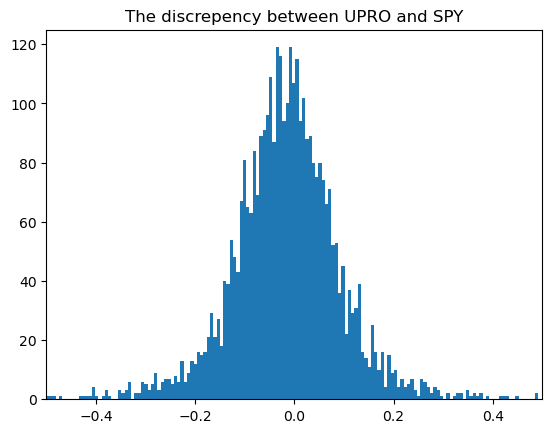

In [ ]:
plt.hist(complete_df["UPRO_3xSPY diff"], bins=1000)
plt.xlim(-0.5,0.5)
plt.title("The discrepency between UPRO and SPY")
plt.show()

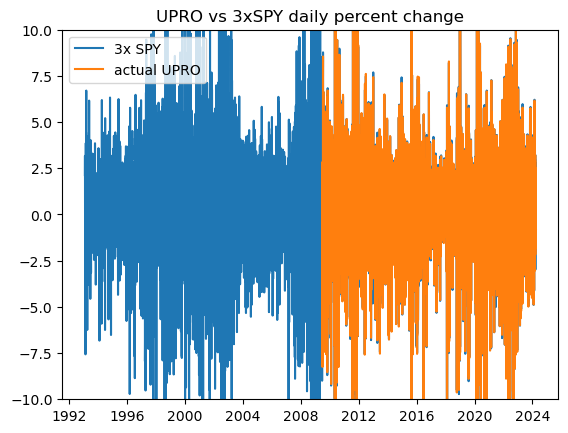

In [ ]:
plt.plot(complete_df["3xSPY"], label = "3x SPY")
plt.plot(complete_df["UPRO"], label ="actual UPRO")
plt.ylim(-10,10)
plt.title("UPRO vs 3xSPY daily percent change")
plt.legend()
plt.show()

In [ ]:
NUM_TRADING_DAYS = 252

average_diff = complete_df['UPRO_3xSPY diff'].mean()
upro_outperform_count = (complete_df['UPRO_3xSPY diff'] > 0).sum()
upro_underperform_count = (complete_df['UPRO_3xSPY diff'] < 0).sum()
annual_diff = complete_df['UPRO_3xSPY diff'].mean() * NUM_TRADING_DAYS
complete_df["3xSPY corrected"] = complete_df["3xSPY"] + average_diff

print(f"Average daily difference (UPRO - 3xSPY): {average_diff:.4f}%")
print(f"Average annual difference (UPRO - 3xSPY): {annual_diff:.4f}%")
print(f"Days UPRO outperformed 3xSPY: {upro_outperform_count}")
print(f"Days UPRO underperformed 3xSPY: {upro_underperform_count}")

Average daily difference (UPRO - 3xSPY): 0.0055%
Average annual difference (UPRO - 3xSPY): 1.3974%
Days UPRO outperformed 3xSPY: 1621
Days UPRO underperformed 3xSPY: 2091


In [ ]:
volatility_upro = complete_df['UPRO'].std()
volatility_3xspy = complete_df['3xSPY'].std()
print(f"Volatility of UPRO: {volatility_upro:.4f}%")
print(f"Volatility of 3xSPY: {volatility_3xspy:.4f}%")

Volatility of UPRO: 3.2617%
Volatility of 3xSPY: 3.5459%


So this is very interesting. According to aggregating over all the years UPRO has been a fund, it seems to outpreform 3x SPY. One would expect this to not be the case do to borrowing costs, the expense ratio, and beta decay. These factors are apparent when looking at the volatility. 3x SPY is more volatile then UPRO meaning that UPRO is not fully able to track 3x SPY to its maximum amount. However, it tracks less which becomes its strength for outperformance (maybe)

In [ ]:
oldest_upro_date = complete_df['UPRO'].dropna().index.min()
filtered_df = complete_df[complete_df.index >= oldest_upro_date]
display(filtered_df)
yearly_sum_upro = filtered_df['UPRO'].dropna().resample('YE').sum()
yearly_sum_3xspy = filtered_df['3xSPY'].dropna().resample('YE').sum()

average_annual_change_upro = yearly_sum_upro.sum() / len(yearly_sum_upro)
average_annual_change_3xspy = yearly_sum_3xspy.sum() / len(yearly_sum_3xspy)

print(f"Average annual change of UPRO: {average_annual_change_upro:.4f}%")
print(f"Average annual change of 3X SPY: {average_annual_change_3xspy:.4f}%")

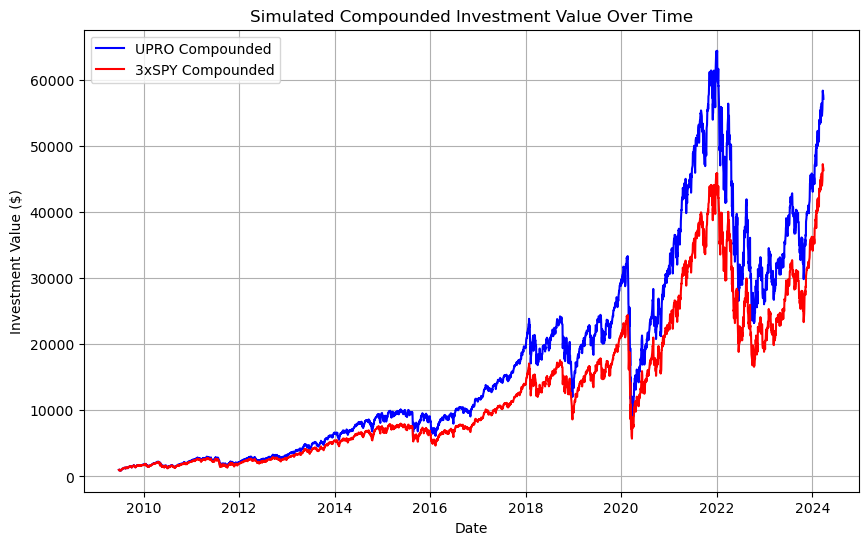

In [ ]:
INITIAL_INVESTMENT = 1000

filtered_df = filtered_df.copy()
filtered_df['UPRO_growth'] = 1 + (filtered_df['UPRO'] / 100)
filtered_df['3xSPY_growth'] = 1 + (filtered_df['3xSPY'] / 100)

filtered_df['UPRO_compounded'] = filtered_df['UPRO_growth'].cumprod() * INITIAL_INVESTMENT
filtered_df['3xSPY_compounded'] = filtered_df['3xSPY_growth'].cumprod() * INITIAL_INVESTMENT

plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['UPRO_compounded'], label='UPRO Compounded', color='blue')
plt.plot(filtered_df.index, filtered_df['3xSPY_compounded'], label='3xSPY Compounded', color='red')
plt.title('Simulated Compounded Investment Value Over Time')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
filtered_df['3xSPY_corrected_growth'] = 1 + (filtered_df["3xSPY corrected"] / 100)
filtered_df['3xSPY_corrected_compounded'] = filtered_df['3xSPY_corrected_growth'].cumprod() * INITIAL_INVESTMENT

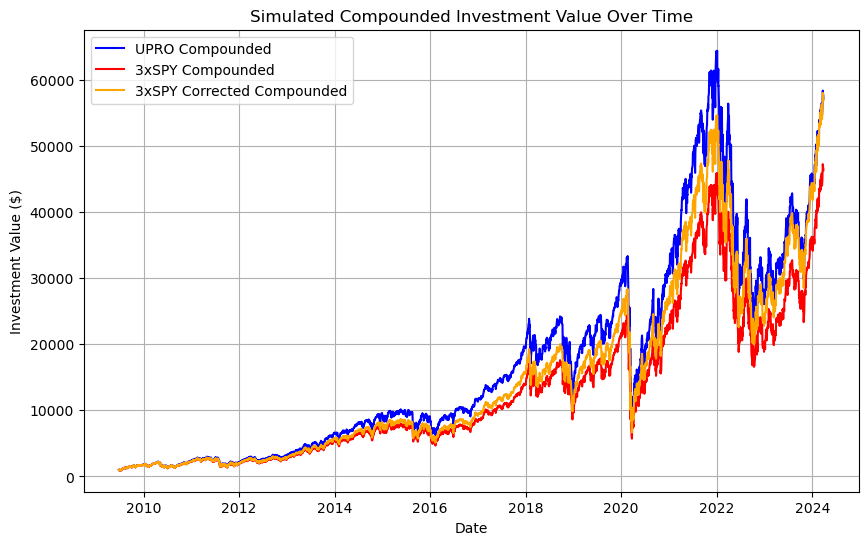

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['UPRO_compounded'], label='UPRO Compounded', color='blue')
plt.plot(filtered_df.index, filtered_df['3xSPY_compounded'], label='3xSPY Compounded', color='red')
plt.plot(filtered_df.index, filtered_df['3xSPY_corrected_compounded'], label='3xSPY Corrected Compounded', color='orange')
plt.title('Simulated Compounded Investment Value Over Time')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')
plt.legend()
plt.grid(True)
plt.show()

Lets try to use daily magnitudes instead to correct for the difference between 3x SPY and UPRO


In [ ]:
positive_days_diff = filtered_df[filtered_df['3xSPY'] > 0]['UPRO_3xSPY diff'].mean()
negative_days_diff = filtered_df[filtered_df['3xSPY'] < 0]['UPRO_3xSPY diff'].mean()

simulated_upro = []
for index, row in complete_df.iterrows():
    if row['3xSPY'] > 0:
        correction = positive_days_diff
    elif row['3xSPY'] < 0:
        correction = negative_days_diff
    else:
        correction = 0  # No change if 3xSPY had zero return
    simulated_upro_return = row['3xSPY'] + correction
    simulated_upro.append(simulated_upro_return)

complete_df['Simulated_UPRO'] = simulated_upro

In [ ]:
complete_df

,3xSPY,3xTLT,UPRO,TMF,UPRO_3xSPY diff,3xSPY corrected,Simulated_UPRO
Date,,,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,2.133713,NaN,NaN,NaN,NaN,2.139258,2.110892
1993-02-02,0.635593,NaN,NaN,NaN,NaN,0.641139,0.612773
1993-02-03,3.171247,NaN,NaN,NaN,NaN,3.176793,3.148427
1993-02-04,1.255230,NaN,NaN,NaN,NaN,1.260776,1.232410
...,...,...,...,...,...,...,...
2024-03-20,2.774791,-0.096854,2.513226,-0.115558,-0.261565,2.780336,2.751971
2024-03-21,0.991411,0.645915,0.845873,0.462780,-0.145538,0.996956,0.968591
2024-03-22,-0.568742,2.868215,-0.469142,2.802309,0.099600,-0.563197,-0.528400


In [ ]:
oldest_upro_date = complete_df['UPRO'].dropna().index.min()
updated_filtered_df = complete_df[complete_df.index >= oldest_upro_date]
display(updated_filtered_df)

,3xSPY,3xTLT,UPRO,TMF,UPRO_3xSPY diff,3xSPY corrected,Simulated_UPRO
Date,,,,,,,
2009-06-26,-0.781947,0.508300,-0.518435,0.578598,0.263512,-0.776401,-0.741605
2009-06-29,2.809236,0.444044,2.837223,0.119847,0.027987,2.814781,2.786415
2009-06-30,-2.427185,-0.506715,-2.387350,-0.598516,0.039834,-2.421639,-2.386843
2009-07-01,1.239820,-1.554397,1.072943,-1.083815,-0.166877,1.245366,1.217000
2009-07-02,-8.188035,0.701534,-8.252508,1.095690,-0.064473,-8.182490,-8.147693
...,...,...,...,...,...,...,...
2024-03-20,2.774791,-0.096854,2.513226,-0.115558,-0.261565,2.780336,2.751971
2024-03-21,0.991411,0.645915,0.845873,0.462780,-0.145538,0.996956,0.968591
2024-03-22,-0.568742,2.868215,-0.469142,2.802309,0.099600,-0.563197,-0.528400


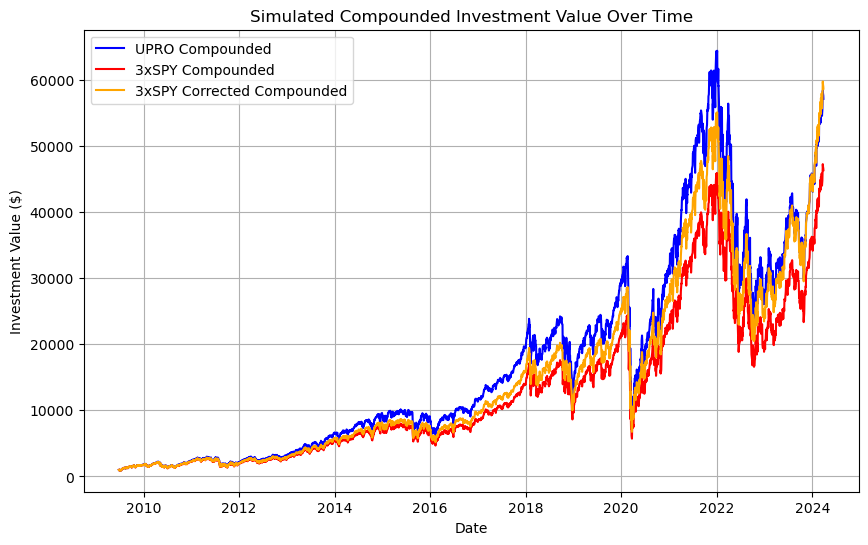

In [ ]:
INITIAL_INVESTMENT = 1000

updated_filtered_df = updated_filtered_df.copy()

updated_filtered_df['UPRO_growth'] = 1 + (updated_filtered_df['UPRO'] / 100)
updated_filtered_df['3xSPY_growth'] = 1 + (updated_filtered_df['3xSPY'] / 100)

updated_filtered_df['UPRO_compounded'] = updated_filtered_df['UPRO_growth'].cumprod() * INITIAL_INVESTMENT
updated_filtered_df['3xSPY_compounded'] = updated_filtered_df['3xSPY_growth'].cumprod() * INITIAL_INVESTMENT

updated_filtered_df['Simulated_UPRO_Growth'] = 1 + (updated_filtered_df["Simulated_UPRO"] / 100)
updated_filtered_df['Simulated_UPRO_Growth_Compounded'] = updated_filtered_df['Simulated_UPRO_Growth'].cumprod() * INITIAL_INVESTMENT

plt.figure(figsize=(10, 6))
plt.plot(updated_filtered_df.index, updated_filtered_df['UPRO_compounded'], label='UPRO Compounded', color='blue')
plt.plot(updated_filtered_df.index, updated_filtered_df['3xSPY_compounded'], label='3xSPY Compounded', color='red')
plt.plot(updated_filtered_df.index, updated_filtered_df['Simulated_UPRO_Growth_Compounded'], label='3xSPY Corrected Compounded', color='orange')
plt.title('Simulated Compounded Investment Value Over Time')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
updated_filtered_df

,3xSPY,3xTLT,UPRO,TMF,UPRO_3xSPY diff,3xSPY corrected,Simulated_UPRO,UPRO_growth,3xSPY_growth,UPRO_compounded,3xSPY_compounded,Simulated_UPRO_Growth,Simulated_UPRO_Growth_Compounded
Date,,,,,,,,,,,,,
2009-06-26,-0.781947,0.508300,-0.518435,0.578598,0.263512,-0.776401,-0.741605,0.994816,0.992181,994.815650,992.180534,0.992584,992.583954
2009-06-29,2.809236,0.444044,2.837223,0.119847,0.027987,2.814781,2.786415,1.028372,1.028092,1023.040784,1020.053222,1.027864,1020.241466
2009-06-30,-2.427185,-0.506715,-2.387350,-0.598516,0.039834,-2.421639,-2.386843,0.976126,0.975728,998.617217,995.294648,0.976132,995.889909
2009-07-01,1.239820,-1.554397,1.072943,-1.083815,-0.166877,1.245366,1.217000,1.010729,1.012398,1009.331809,1007.634512,1.012170,1008.009890
2009-07-02,-8.188035,0.701534,-8.252508,1.095690,-0.064473,-8.182490,-8.147693,0.917475,0.918120,926.036620,925.129046,0.918523,925.880340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-20,2.774791,-0.096854,2.513226,-0.115558,-0.261565,2.780336,2.751971,1.025132,1.027748,57857.119846,46765.962978,1.027520,59152.674992
2024-03-21,0.991411,0.645915,0.845873,0.462780,-0.145538,0.996956,0.968591,1.008459,1.009914,58346.517535,47229.605829,1.009686,59725.622315
2024-03-22,-0.568742,2.868215,-0.469142,2.802309,0.099600,-0.563197,-0.528400,0.995309,0.994313,58072.789735,46960.991232,0.994716,59410.032164


/usr/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


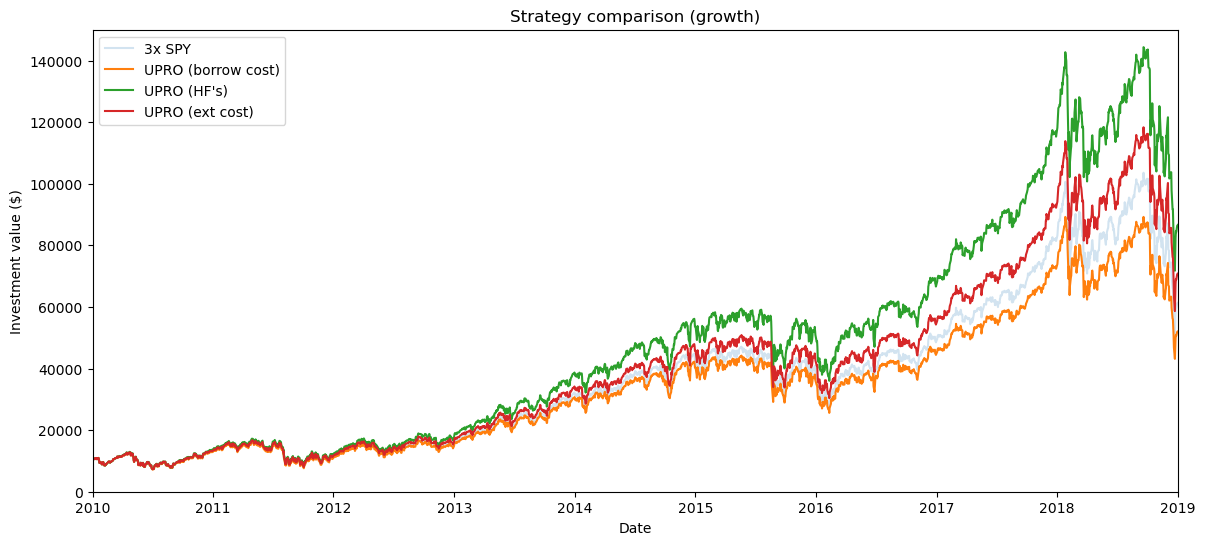

In [ ]:
plt.figure(figsize=(14, 6))  # Adjust the width as needed

df = growth(joined_df.join(updated_filtered_df['Simulated_UPRO']), start)
plt.plot(df["3xSPY"], label="3x SPY", alpha=0.2)
plt.plot(df["UPRO_ours"], label="UPRO (borrow cost)")
plt.plot(df["UPRO_sim"], label = "UPRO (HF's)")
plt.plot(df["Simulated_UPRO"], label = "UPRO (ext cost)")
plt.title("Strategy comparison (growth)")
plt.xlabel('Date')
plt.ylabel('Investment value ($)')

plt.legend()
plt.ylim(0, 150000)
plt.xlim(pd.to_datetime(start), pd.to_datetime("2019"))
plt.show()

